# ORCA12 spinup phase

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
from scipy.interpolate import griddata

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:44479 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


## Read mesh

In [5]:
ds_m = xr.open_dataset('/gxfs_work1/geomar/smomw352/mask_orca12.nc')
tmask = ds_m['tmask'][0,:,:,:]
ds_h = xr.open_dataset('/gxfs_work1/geomar/smomw352/mesh_hgr_orca12.nc')
e1t = ds_h['e1t'][0,:,:]
e2t = ds_h['e2t'][0,:,:]

## Read data

In [6]:
expnames = ['FOCI_BJK017','FOCI_BJK017','FOCI_BJK017',
            'FOCI_BJK019','FOCI_BJK019']
times = [slice('1950-02-01','1950-12-31'),
         slice('1951-01-01','1951-12-31'),
         slice('1952-02-01','1952-12-31'),
         slice('1953-02-01','1953-12-31'),
         slice('1954-01-01','1954-12-31')]

In [7]:
t_5d_all = []
u_5d_all = []
v_5d_all = []
#i_5d_all = []

for i, (exp,time) in enumerate( zip(expnames, times) ):
    ddir = '/gxfs_work1/geomar/smomw352/esm-experiments/%s/outdata/nemo/' % (exp,)
    tfiles = '%s/%s_5d_*_grid_T.nc' % (ddir,exp)
    print(tfiles)
    t_5d = xr.open_mfdataset(tfiles,combine='by_coords').rename({'time_counter':'time'}).sel(time=time)
    
    ufiles = '%s/%s_5d_*_grid_U.nc' % (ddir,exp)
    u_5d = xr.open_mfdataset(ufiles,combine='by_coords').rename({'time_counter':'time'}).sel(time=time)
    
    vfiles = '%s/%s_5d_*_grid_V.nc' % (ddir,exp)
    v_5d = xr.open_mfdataset(vfiles,combine='by_coords').rename({'time_counter':'time'}).sel(time=time)
    
    #ifiles = '%s/%s_5d_*_icemod.nc' % (ddir,exp)
    #i_5d = xr.open_mfdataset(ifiles,combine='by_coords').rename({'time_counter':'time'}).sel(time=time)

    t_5d_all.append(t_5d)
    u_5d_all.append(u_5d)
    v_5d_all.append(v_5d)
    #i_5d_all.append(i_5d)

/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK017/outdata/nemo//FOCI_BJK017_5d_*_grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK017/outdata/nemo//FOCI_BJK017_5d_*_grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK017/outdata/nemo//FOCI_BJK017_5d_*_grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo//FOCI_BJK019_5d_*_grid_T.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo//FOCI_BJK019_5d_*_grid_T.nc


In [8]:
t_5d

<xarray.Dataset>
Dimensions:               (y: 3059, x: 4322, deptht: 75, time: 71, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(3059, 4322), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(3059, 4322), meta=np.ndarray>
  * deptht                (deptht) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered         (time) datetime64[ns] dask.array<chunksize=(6,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1954-01-03T12:00:00 ... 1954-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/18)
    deptht_bounds         (time, deptht, axis_nbounds) float32 dask.array<chunksize=(6, 75, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(6, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(6, 2), meta=np.ndarray>
    toce                  (time, deptht, y, x) float32 dask.array<chunksize=(6, 75, 3059, 4322), meta=np.ndarray>
    soce                  (time, deptht, y, x) float32 dask.array<chunksize=(6, 75, 3059, 4322), meta=np.ndarray>
    mldr10_1              (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    ...                    ...
    qsr                   (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    qt                    (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    qns_cal               (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    sst                   (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    sss                   (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
    ssh                   (time, y, x) float32 dask.array<chunksize=(6, 3059, 4322), meta=np.ndarray>
Attributes:
    name:         FOCI_BJK019_5d_19530101_19530131_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2022-Aug-23 19:03:38 GMT
    uuid:         f21abaf7-9b6d-40ff-9f59-7e7156c178a4
    history:      Thu Sep  1 12:02:15 2022: ncks -O -7 --no-alphabetize -L 1 ...
    NCO:          netCDF Operators version 4.9.1 (Homepage = http://nco.sf.ne...

## EKE

In [73]:
ekes_all = []
for ji, (ds_u, ds_v) in enumerate( zip(u_5d_all, v_5d_all) ):
    
    ekes = 0.5 * (ds_u['uoce'].sel(depthu=0,method='nearest')**2 + ds_v['voce'].sel(depthv=0,method='nearest')**2)
    ekes_y = ekes.mean('time').compute()
    print(ekes_y)
    ekes_all.append(ekes_y)

ds_ekes = xr.concat(ekes_all, dim='time')

<xarray.DataArray (y: 3059, x: 4322)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    depthu   float32 0.5058
    depthv   float32 0.5058
Dimensions without coordinates: y, x
<xarray.DataArray (y: 3059, x: 4322)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    depthu   float32 0.5058
    depthv   float32 0.5058
Dimensions without coordinates: y, x
<xarray.DataArray (y: 3059, x: 4322)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
  

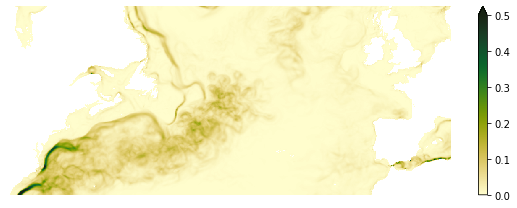

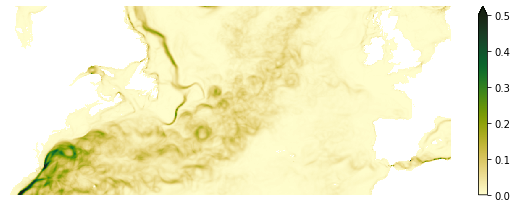

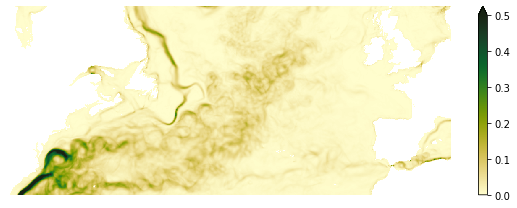

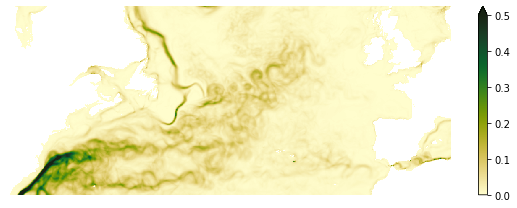

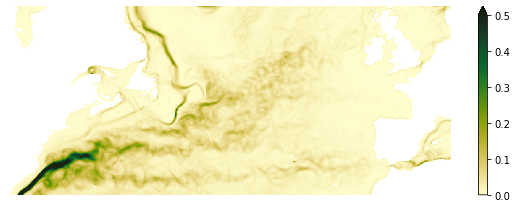

In [80]:
for ji, ekes in enumerate(ekes_all): 
    fig1 = plt.figure(figsize=(8,3))
    ax1 = fig1.add_subplot(111)
    ax1.set_facecolor('black')
    ekes.where(ekes>0).plot(ax=ax1, vmin=0,vmax=0.5, 
                            cmap=cmocean.cm.speed,
                            rasterized=True)
    ax1.set_axis_off()
    ax1.set_title('')
    
    # 410, 314 on ORCA05 is start for VIKING10
    xmin, ymin = 410*6, 314*6
    xmax, ymax = 586*6, ymin+480
    ax1.set_xlim([xmin,xmax])
    ax1.set_ylim([ymin,ymax])
    fig1.tight_layout()
    #fig1.savefig('figures/eke_sfc_natl_%d.pdf' % (ji,), format='pdf', dpi=150)

In [75]:
eke_i_all = []

x1,x2,y1,y2 = 2400,3550, 1630,2750

totarea = (tmask[0,:,:] * e1t*e2t).sel(x=slice(x1,x2), y=slice(y1,y2)).sum(('x','y'))
for ji, eke in enumerate(ekes_all):
    eke_i = (eke * tmask[0,:,:] * e1t * e2t).sel(x=slice(x1,x2), y=slice(y1,y2)).sum(('x','y')) / totarea
    eke_i_all.append(eke_i.compute())

Text(0, 0.5, 'Global-mean EKE')

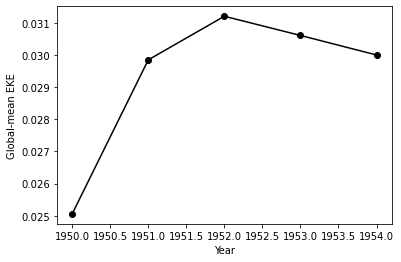

In [76]:
fig1, ax1 = plt.subplots(1,1)
years = 1950 + np.arange(0,5)
ax1.plot(years,eke_i_all,'-ok')
ax1.set_xlabel('Year')
ax1.set_ylabel('Global-mean EKE')

## North Atlantic corner

In [9]:
sst_all = []
for ji, ds_t in enumerate( t_5d_all ):
    
    sst = ds_t['sst']
    
    # Compute time mean
    t_y = sst.mean('time').compute()
    
    sst_all.append(t_y)

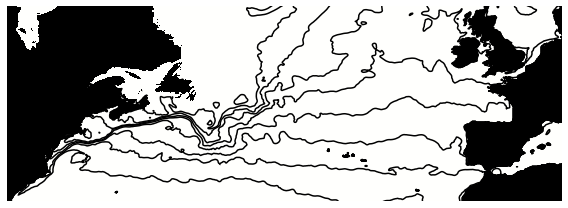

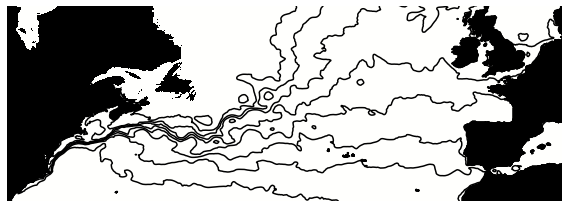

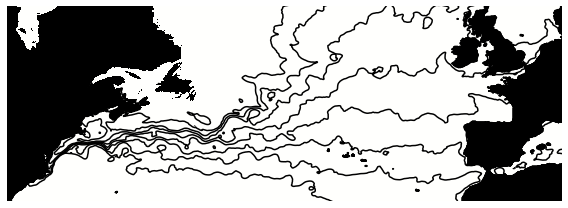

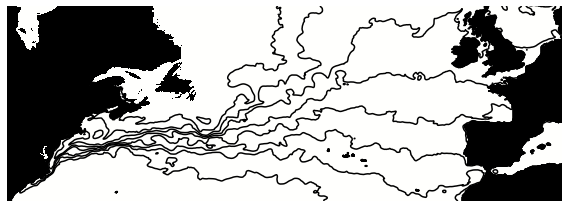

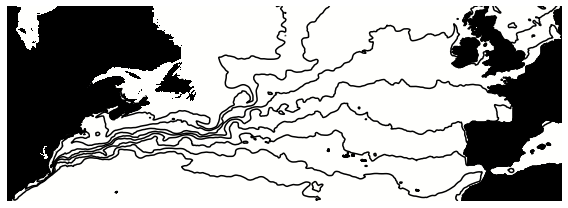

In [11]:
for ji, t in enumerate( sst_all ):
    
    fig1, ax1 = plt.subplots(1,1, figsize=(8,3))
    tmask[0,:,:].plot(ax=ax1, vmin=0, vmax=1, 
                      cmap=cmocean.cm.gray, 
                      add_colorbar=False,
                      rasterized=True)
    t.plot.contour(ax=ax1, levels=np.arange(6,22,2), colors='k')
    
    # 410, 314 on ORCA05 is start for VIKING10
    xmin, ymin = 410*6, 314*6
    xmax, ymax = 586*6, ymin+480 #487
    
    ax1.set_axis_off()
    ax1.set_title('')
    ax1.set_xlim([xmin,xmax])
    ax1.set_ylim([ymin,ymax])
    fig1.tight_layout()
    fig1.savefig('figures/Natl_sst_%d.pdf' % (ji,),format='pdf',dpi=150)

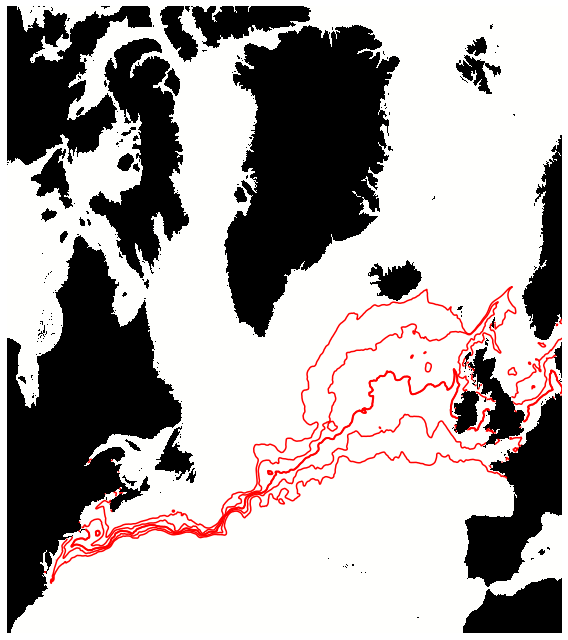

In [28]:
for ji, t in enumerate( sst_all[-1:] ):
    
    _t = t.where(tmask[0,:,:] != 0)
    
    fig1, ax1 = plt.subplots(1,1, figsize=(8,9))
    tmask[0,:,:].plot(ax=ax1, vmin=0, vmax=1, 
                      cmap=cmocean.cm.gray, 
                      add_colorbar=False,
                      rasterized=True)
    _t.plot.contour(ax=ax1, levels=np.arange(8,13,1), colors='r')
    _t.plot.contour(ax=ax1, levels=[10], colors='r', linewidths=2)
    
    # VIKING10 on the ORCA12 grid
    xmin, ymin = 410*6, 314*6
    xmax, ymax = 586*6, 487*6
    
    ax1.set_axis_off()
    ax1.set_title('')
    ax1.set_xlim([xmin,xmax])
    ax1.set_ylim([ymin,ymax])
    fig1.tight_layout()
    fig1.savefig('figures/Natl_sst.pdf',format='pdf',dpi=150)

## EN4

In [18]:
times = slice('1950-01-01','1951-01-01')
en4 = '/gxfs_work1/geomar/smomw352/en4/EN.4.2.1.f.analysis.g10.*.nc'
ds_e = xr.open_mfdataset(en4,combine='by_coords').sel(time=times)

In [19]:
sst_e = ds_e['temperature'].sel(depth=0,method='nearest').mean('time')

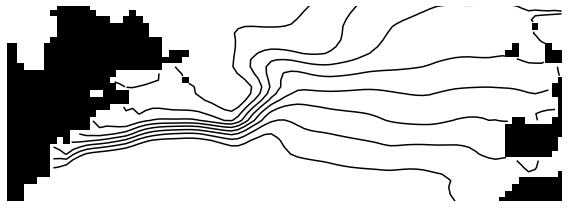

In [20]:
tmask = (sst_e.where(sst_e > -2)/sst_e).fillna(0)
fig1, ax1 = plt.subplots(1,1,figsize=(8,3))
#tmask.plot(ax=ax1)
tmask[:,:].plot(ax=ax1, vmin=0, vmax=1, 
                cmap=cmocean.cm.gray, 
                add_colorbar=False,
                rasterized=True)
levels = np.arange(6,22,2) + 273.15
sst_e.plot.contour(ax=ax1, levels=levels, colors='k')

ax1.set_axis_off()
ax1.set_title('')
ax1.set_xlim([276,360])
ax1.set_ylim([31,60])
fig1.tight_layout()
fig1.savefig('figures/en4_sst_1950.pdf',format='pdf',dpi=150)

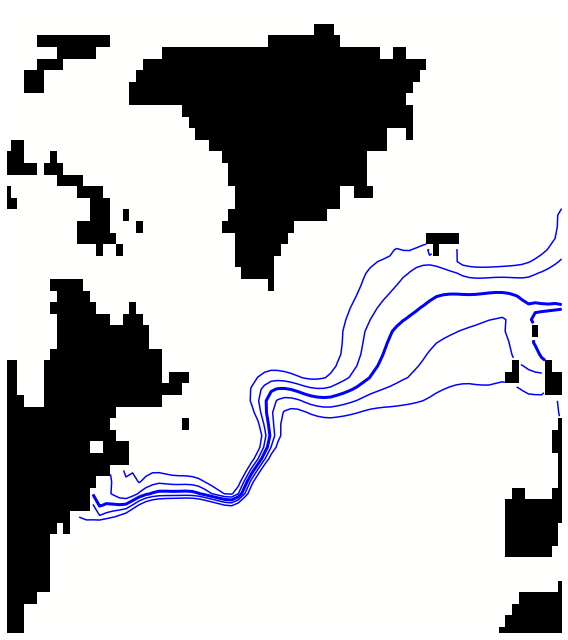

In [24]:
tmask = (sst_e.where(sst_e > -2)/sst_e).fillna(0)
fig1, ax1 = plt.subplots(1,1,figsize=(8,9))
#tmask.plot(ax=ax1)
tmask[:,:].plot(ax=ax1, vmin=0, vmax=1, 
                cmap=cmocean.cm.gray, 
                add_colorbar=False,
                rasterized=True)
levels = np.arange(8,13,1) + 273.15
sst_e.plot.contour(ax=ax1, levels=levels, colors='b')
sst_e.plot.contour(ax=ax1, levels=[283.15], colors='b', linewidths=3)

ax1.set_axis_off()
ax1.set_title('')
ax1.set_xlim([276,360])
ax1.set_ylim([31,85])
fig1.tight_layout()
fig1.savefig('figures/en4_sst_1950_vik.pdf',format='pdf',dpi=150)